In [1]:
!curl -fsSL https://ollama.com/install.sh | sh
!pip install gymnasium==1.2.0 vizdoom==1.2.4 pillow==11.3.0 langchain==0.3.27 langchain-openai==0.3.28

ERROR: This script is intended to run on Linux only.


In [2]:
import getpass

try:
    key = getpass.getpass("Please openai api key: ")
except Exception as e:
    print(f"An error occurred: {e}")
import os
os.environ["OPENAI_API_KEY"] = key

/Users/tripp/miniconda3/envs/ai-agent/lib/python3.12/site-packages/vizdoom/gymnasium_wrapper/base_gymnasium_env.py:84: UserWarning: Detected screen format CRCGCB. Only RGB24 and GRAY8 are supported in the Gymnasium wrapper. Forcing RGB24.
  warnings.warn(


Discrete(4)


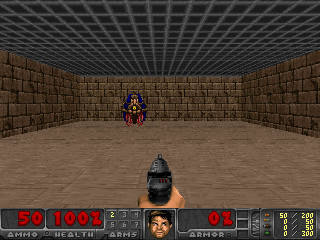

attack


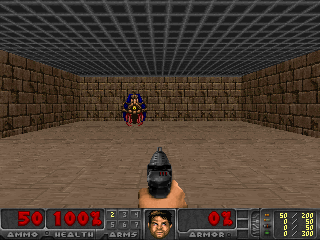

attack


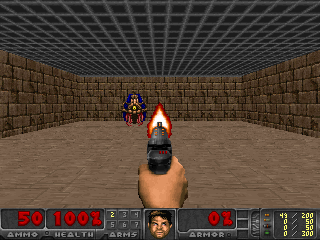

move_left


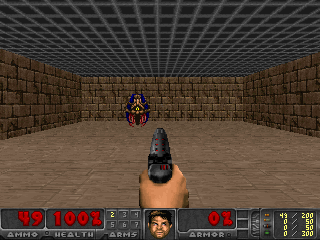

attack


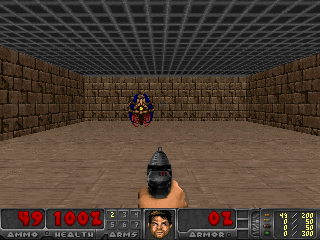

attack


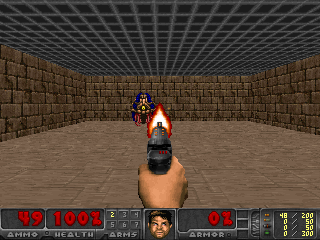

attack


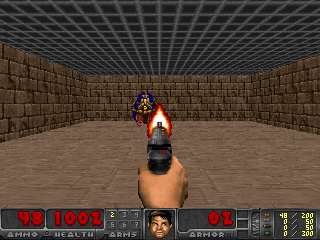

move_left


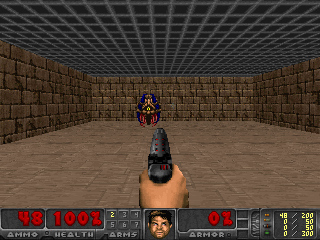

attack


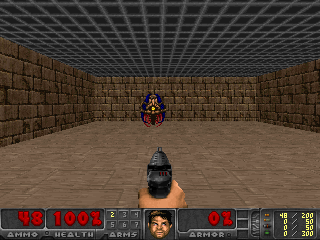

attack


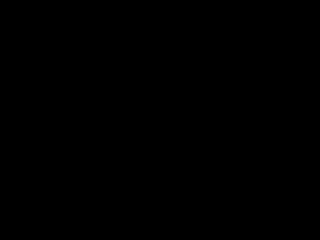

Total reward: 57.0


In [4]:
import gymnasium
from vizdoom import gymnasium_wrapper
from PIL import Image
from IPython.display import display
import base64
from langchain_openai import ChatOpenAI
import io

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)


DO_NOTHING = 0
MOVE_LEFT = 3
MOVE_RIGHT = 2
ATTACK = 1


def pil_to_base64(img):
    # img = img.resize((256, 192))
    # png bytes
    png_bytes = io.BytesIO()
    img.save(png_bytes, format="PNG")
    result = base64.b64encode(png_bytes.getvalue()).decode("utf-8")
    return result


def make_message(img):
    return {
        "role": "user",
        "content": [
            {
                "type": "text",
            "text": "You are playing a game of Doom. You are given an image of the current state of the game. Choose an action out of one of the following: move_left, move_right, attack. Your goal is to defeat the enemy by getting them to the center of your crosshair before attacking them. Do not include any other text in your response, just one of the above actions. You have 3 actions to choose from. The enemy is purple, you can move yourself to align with the enemy before shooting by moving left or right. If the enemy is on the right side of the screen, move right. If the enemy is on the left side of the screen, move left. If the enemy is in the center of the screen, attack. Move towards the purple enemy and then attack. DO NOT MOVE AWAY FROM THE ENEMY. MAKE SURE THE ENEMY IS IN THE CENTER OF THE SCREEN ON YOUR CROSSHAIR BEFORE ATTACKING.",
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{pil_to_base64(img)}",
                },
            },
        ],
    }

def get_response(img):
    message = make_message(img)
    response = llm.invoke([message])
    return response.content

def get_action(img):
    response = get_response(img)
    if response == "move_left":
        print("move_left")
        return MOVE_LEFT
    elif response == "move_right":
        print("move_right")
        return MOVE_RIGHT
    elif response == "attack":
        print("attack")
        return ATTACK
    else:
        print("Invalid response")
        return DO_NOTHING

env = gymnasium.make("VizdoomBasic-v0", frame_skip=4)
print(env.action_space)
last_frame = None

DISPLAY_FRAME_SKIP = 1


def display_frame(obs):
    screen = obs["screen"]
    img = Image.fromarray(screen)
    display(img)

def policy(obs):
    global last_frame
    screen = obs["screen"]
    img = Image.fromarray(screen)
    if last_frame % DISPLAY_FRAME_SKIP == 0:
        display(img)
    last_frame += 1
    return get_action(img)


def run_agent():
    global last_frame

    last_frame = 0

    total_reward = 0

    observation, info = env.reset()
    while True:
        action = policy(observation)  # this is where you would insert your policy
        observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward


        if terminated or truncated:
            # observation, info = env.reset()
            display_frame(observation)
            break

    print(f"Total reward: {total_reward}")




run_agent()
env.close()